In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import random
import glob
import cv2
from tqdm import tqdm
from PIL import Image

from timeit import default_timer as timer

In [2]:
# Define a transformation pipeline for preprocessing images
transform = transforms.Compose(
    [
        # 1. Convert the input image (PIL Image or NumPy array) into a PyTorch tensor.
        #    - Converts pixel values from range [0, 255] to [0.0, 1.0].
        transforms.ToTensor(),

        # 2. Randomly flip the image horizontally with probability 0.5.
        #    - Useful for data augmentation to improve model generalization.
        transforms.RandomHorizontalFlip(p=0.5),

        # 3. Normalize the image tensor using mean=0.5 and std=0.5.
        #    - Formula: (x - mean) / std
        #    - This maps values from [0.0, 1.0] to [-1.0, 1.0].
        transforms.Normalize((0.5,), (0.5,))
    ]
)

"""
Docstring:
----------
This transformation pipeline is designed for preprocessing image data
before feeding it into a neural network.

Steps applied to each image:
1. Convert the image to a tensor with values in [0,1].
2. Apply a random horizontal flip with probability 0.5
   (data augmentation).
3. Normalize the tensor so that pixel values fall in [-1,1].

Typical use case: applied to image datasets (e.g., MNIST, CIFAR-10)
to improve training stability and generalization.
"""

'\nDocstring:\n----------\nThis transformation pipeline is designed for preprocessing image data\nbefore feeding it into a neural network.\n\nSteps applied to each image:\n1. Convert the image to a tensor with values in [0,1].\n2. Apply a random horizontal flip with probability 0.5\n   (data augmentation).\n3. Normalize the tensor so that pixel values fall in [-1,1].\n\nTypical use case: applied to image datasets (e.g., MNIST, CIFAR-10)\nto improve training stability and generalization.\n'

In [3]:
# Load the FashionMNIST training dataset
train_dataset_FashionMNIST = torchvision.datasets.FashionMNIST(
    root="data",          # Directory where the dataset will be stored/downloaded
    train=True,           # True = load the training split (60,000 images)
    download=True,        # Download the dataset if it's not already on disk
    transform=transform   # Apply preprocessing pipeline (ToTensor, augmentation, normalization)
)

# Load the FashionMNIST test dataset
test_dataset_FashionMNIST = torchvision.datasets.FashionMNIST(
    root="data",          # Same directory used for training dataset
    train=False,          # False = load the test split (10,000 images)
    download=True,        # Download if not already present
    transform=transform   # Apply the same preprocessing pipeline as training
)

100%|██████████| 26.4M/26.4M [00:00<00:00, 112MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.77MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 58.4MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.94MB/s]


In [4]:
# Load the MNIST training dataset
train_dataset_MNIST = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# Load the MNIST test dataset
test_dataset_MNIST = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 341kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


In [5]:
# Load the CIFAR10 training dataset
train_dataset_CIFAR10 = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform
)

# Load the CIFAR10 test dataset
test_dataset_CIFAR10 = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=transform
)


100%|██████████| 170M/170M [00:08<00:00, 20.7MB/s]


In [6]:
def create_dataloader(train_raw_dataset, test_raw_dataset, batch_size):
    """
    Create PyTorch DataLoaders for training and testing datasets.

    Parameters
    ----------
    train_raw_dataset : torch.utils.data.Dataset
        The training dataset (e.g., MNIST, CIFAR-10).
    test_raw_dataset : torch.utils.data.Dataset
        The test dataset (e.g., MNIST, CIFAR-10).
    batch_size : int
        Number of samples per batch to load.

    Returns
    -------
    train_dataloader : torch.utils.data.DataLoader
        DataLoader for the training dataset with shuffling enabled.
    test_dataloader : torch.utils.data.DataLoader
        DataLoader for the test dataset with shuffling disabled.
    """
    train_dataloader = DataLoader(
        dataset=train_raw_dataset,
        batch_size=batch_size,
        num_workers=2,   # number of subprocesses to use for data loading
        shuffle=True     # shuffle only for training
    )

    test_dataloader = DataLoader(
        dataset=test_raw_dataset,
        batch_size=batch_size,
        num_workers=2,
        shuffle=False    # don't shuffle test data
    )

    return train_dataloader, test_dataloader


In [7]:
# Create dataloaders for FashionMNIST
train_dataloader_FashionMNIST, test_dataloader_FashionMNIST = create_dataloader(
    train_dataset_FashionMNIST, test_dataset_FashionMNIST, batch_size=128
)

# Create dataloaders for MNIST
train_dataloader_MNIST, test_dataloader_MNIST = create_dataloader(
    train_dataset_MNIST, test_dataset_MNIST, batch_size=128
)

# Create dataloaders for CIFAR-10
train_dataloader_CIFAR10, test_dataloader_CIFAR10 = create_dataloader(
    train_dataset_CIFAR10, test_dataset_CIFAR10, batch_size=128
)

In [8]:
print("FashionMNIST classes:", train_dataset_FashionMNIST.classes)
print("MNIST classes:", train_dataset_MNIST.classes)
print("CIFAR-10 classes:", train_dataset_CIFAR10.classes)

FashionMNIST classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
MNIST classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
CIFAR-10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
def show_sample(data_dataloader, mean, std):
    batch_images, batch_labels = next(iter(data_dataloader))
    normed_image = batch_images[0]      # first image in batch
    label = batch_labels[0]             # its label

    # Denormalize: x * std + mean
    original_image = (normed_image * std) + mean

    # Remove channel dimension (1, H, W) -> (H, W)
    plt.imshow(original_image.permute(1, 2, 0), cmap="gray")
    plt.title(f"Label: {label.item()}")
    plt.axis("off")
    plt.show()
    print(f"Image size: {original_image.shape}")

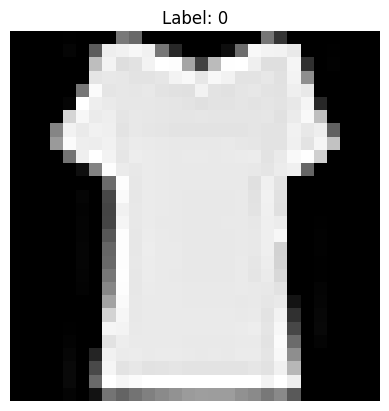

Image size: torch.Size([1, 28, 28])


In [ ]:
show_sample(train_dataloader_FashionMNIST, mean=0.5, std=0.5)

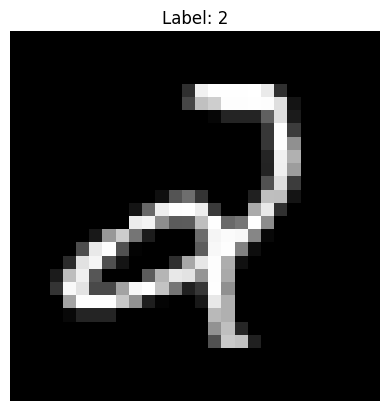

Image size: torch.Size([1, 28, 28])


In [ ]:
show_sample(train_dataloader_MNIST, mean=0.5, std=0.5)

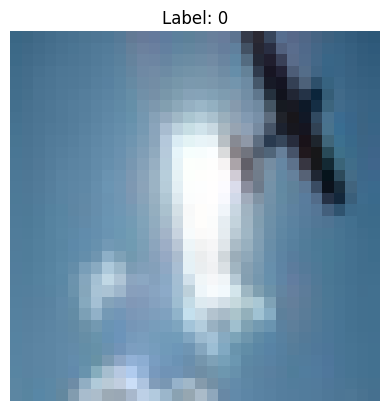

Image size: torch.Size([3, 32, 32])


In [ ]:
show_sample(train_dataloader_CIFAR10, mean=0.5, std=0.5)

# First Model

In [55]:
class SCNNB(nn.Module):
    """
    Shallow Convolutional Neural Network with Batch Normalization (SCNNB).

    Architecture (for input 28x28x1 like MNIST):
        - Conv(3x3, 32 filters, padding=1) + BN + ReLU
        - MaxPool(2x2)
        - Conv(3x3, 64 filters, padding=1) + BN + ReLU
        - MaxPool(2x2)
        - Flatten
        - FC(3136 -> 1280) + ReLU
        - Dropout(0.5)
        - FC(1280 -> num_classes)

    Notes:
        - Padding=1 keeps spatial size before pooling.
        - For MNIST (1x28x28) → Flatten=3136 (64*7*7).
        - For CIFAR-10 (3x32x32) → Flatten=4096 (64*8*8).
        - Forward returns raw logits; use nn.CrossEntropyLoss for training.
    """

    def __init__(self, in_channels: int = 1, num_classes: int = 10, input_size: int = 28):
        """
        Initialize the SCNNB model.

        Args:
            in_channels (int): Number of input channels (1 for grayscale, 3 for RGB).
            num_classes (int): Number of output classes.
            input_size (int): Height/Width of the input image (assumed square).
        """
        super().__init__()
        self.input_size  = input_size
        self.in_channels = in_channels
        self.num_classes = num_classes

        # ---- Feature extractor ----
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # ---- Classifier ----
        feat_dim   = self._calc_feat_dim()  # Dynamically compute flattened feature dimension
        self.fc1   = nn.Linear(feat_dim, 1280)
        self.drop1 = nn.Dropout(p=0.5)
        self.fc_out= nn.Linear(1280, num_classes)

    def _calc_feat_dim(self) -> int:
        """
        Compute the number of features after the convolution + pooling layers.
        This ensures the fully connected layer is correctly sized for any input.

        Returns:
            int: Flattened feature dimension.
        """
        with torch.no_grad():
            device = next(self.parameters()).device  # Match the device of the model
            tmp = torch.zeros((1, self.in_channels, self.input_size, self.input_size), device=device)
            tmp = self.pool1(F.relu(self.bn1(self.conv1(tmp))))
            tmp = self.pool2(F.relu(self.bn2(self.conv2(tmp))))
            return tmp.numel()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of SCNNB.

        Args:
            x (torch.Tensor): Input tensor of shape (N, C, H, W).

        Returns:
            torch.Tensor: Logits of shape (N, num_classes).
        """
        # ---- Feature extraction ----
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))

        # ---- Classification head ----
        x = torch.flatten(x, start_dim=1)   # Flatten to (N, feat_dim)
        x = F.relu(self.fc1(x))             # Fully connected hidden layer
        x = self.drop1(x)                   # Dropout for regularization
        logits = self.fc_out(x)             # Output logits (no softmax)
        return logits


In [56]:
num_classes_MNIST = len(train_dataset_MNIST.classes)
num_classes_FashionMNIST = len(train_dataset_FashionMNIST.classes)
num_classes_CIFAR10 = len(train_dataset_CIFAR10.classes)

In [57]:
model1 = SCNNB(in_channels=1, num_classes=num_classes_MNIST, input_size=28)
model2 = SCNNB(in_channels=1, num_classes=num_classes_FashionMNIST, input_size=28)
model3 = SCNNB(in_channels=3, num_classes=num_classes_CIFAR10, input_size=32)

In [13]:
random_sample = torch.randn((1, 3, 32, 32))
model3(random_sample).shape

torch.Size([1, 10])

# Second Model

In [58]:
class SCNNB_a(nn.Module):
    """
    Shallow Convolutional Neural Network with automatic feature dimension calculation.

    Architecture:
        - Two convolutional layers with ReLU activation and MaxPooling
        - Batch normalization after the second convolution
        - Fully connected classifier with one hidden layer, ReLU, and Dropout
        - Output layer produces logits for classification

    Attributes:
        in_channels (int): Number of channels in the input image (e.g., 1 for grayscale, 3 for RGB)
        image_size (int): Height and width of the square input image
        num_classes (int): Number of output classes for classification
        CNN_block (nn.Sequential): Feature extraction layers (convolutions + activations + pooling)
        classifier (nn.Sequential): Fully connected layers for classification
    """

    def __init__(self, in_channels=1, num_classes=10, image_size=28):
        super().__init__()

        self.in_channels = in_channels
        self.image_size = image_size
        self.num_classes = num_classes

        # Feature extraction block
        self.CNN_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self._calc_feat_dim(), out_features=1280),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1280, out_features=self.num_classes)
        )

    def _calc_feat_dim(self) -> int:
        """
        Compute the flattened feature dimension after CNN_block.

        This ensures the linear layer is correctly sized for any input image size.

        Returns:
            int: Number of features after flattening the CNN output
        """
        with torch.no_grad():
            device = next(self.parameters()).device  # match the model's device
            tmp = torch.zeros((1, self.in_channels, self.image_size, self.image_size), device=device)
            tmp = self.CNN_block(tmp)
            return tmp.numel()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, image_size, image_size)

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes)
        """
        x = self.CNN_block(x)
        x = self.classifier(x)
        return x

In [59]:
model4 = SCNNB_a(in_channels=1, num_classes=10, image_size=28)
model5 = SCNNB_a(in_channels=1, num_classes=10, image_size=28)
model6 = SCNNB_a(in_channels=3, num_classes=10, image_size=32)

# Third Model

In [60]:
class SCNNB_b(nn.Module):
    """
    Shallow Convolutional Neural Network with automatic feature dimension calculation.

    Architecture:
        - Two convolutional layers with ReLU activation and MaxPooling
        - No Batch Normalization
        - Fully connected classifier with one hidden layer, ReLU, and Dropout
        - Output layer produces logits for classification

    Attributes:
        in_channels (int): Number of channels in the input image (e.g., 1 for grayscale, 3 for RGB)
        image_size (int): Height and width of the square input image
        num_classes (int): Number of output classes for classification
        CNN_block (nn.Sequential): Feature extraction layers (convolutions + activations + pooling)
        classifier (nn.Sequential): Fully connected layers for classification
    """

    def __init__(self, in_channels=1, num_classes=10, image_size=28):
        super().__init__()

        self.in_channels = in_channels
        self.image_size = image_size
        self.num_classes = num_classes

        # Feature extraction block
        self.CNN_block = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self._calc_feat_dim(), out_features=1280),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=1280, out_features=self.num_classes)
        )

    def _calc_feat_dim(self) -> int:
        """
        Compute the flattened feature dimension after CNN_block.

        This ensures the linear layer is correctly sized for any input image size.

        Returns:
            int: Number of features after flattening the CNN output
        """
        with torch.no_grad():
            device = next(self.parameters()).device  # match the model's device
            tmp = torch.zeros((1, self.in_channels, self.image_size, self.image_size), device=device)
            tmp = self.CNN_block(tmp)
            return tmp.numel()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_channels, image_size, image_size)

        Returns:
            torch.Tensor: Output logits of shape (batch_size, num_classes)
        """
        x = self.CNN_block(x)
        x = self.classifier(x)
        return x

In [61]:
model7 = SCNNB_b(in_channels=1, num_classes=10, image_size=28)
model8 = SCNNB_b(in_channels=1, num_classes=10, image_size=28)
model9 = SCNNB_b(in_channels=3, num_classes=10, image_size=32)

# Define `train_step` & `test_step`

In [62]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn, device):
    """
    Performs one full training epoch over the provided data loader.

    Args:
        model (torch.nn.Module): The neural network model to train.
        data_loader (DataLoader): DataLoader providing training batches.
        loss_fn (callable): Loss function to compute the error.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        accuracy_fn (callable): Function to calculate accuracy.
        device (torch.device): Device to run computations on (CPU or GPU).

    Returns:
        tuple: (average_train_loss, average_train_accuracy) over the epoch.
    """
    model.to(device)  # Move model to the specified device (CPU or GPU)
    train_loss, train_acc, counter = 0, 0, 0

    with tqdm(data_loader, desc='  train') as train_tqdm:
        for X, y in train_tqdm:
            # Move data to the specified device
            X, y = X.to(device), y.to(device)

            # Forward pass: predict outputs
            y_pred = model(X)

            # Compute the loss for current batch
            loss = loss_fn(y_pred, y)

            # Accumulate loss and accuracy values
            train_loss += loss.item()  # Convert tensor loss to float before accumulating
            train_acc += accuracy_fn(true=y, pred=y_pred).item()

            counter += 1  # Increment batch counter

            # Update tqdm progress bar postfix with current average accuracy and loss
            train_tqdm.set_postfix(
                train_acc=train_acc / counter,
                train_loss=train_loss / counter,
                refresh=True
            )

             # Zero gradients before backward pass
            optimizer.zero_grad()

            # Backward pass: compute gradients
            loss.backward()

            # Update model parameters
            optimizer.step()

        # Compute average loss and accuracy over all batches
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)

    return train_loss, train_acc


In [63]:
def test_step(model, data_loader, loss_fn, accuracy_fn, device):
    """
    Evaluate a trained model on a test dataset.

    Args:
        model (torch.nn.Module): The trained PyTorch model to evaluate.
        data_loader (torch.utils.data.DataLoader): DataLoader containing the test dataset.
        loss_fn (callable): Loss function used to compute the evaluation loss.
        accuracy_fn (callable): Function to compute accuracy.
                                 Should accept `true` (ground truth labels) and `pred` (model predictions).
        device (torch.device or str): Device to perform computation on ('cpu' or 'cuda').

    Returns:
        tuple:
            test_loss (float) - Average loss over the test dataset.
            test_acc (float) - Average accuracy over the test dataset.
    """

    # Move the model to the specified device (CPU or GPU)
    model.to(device)

    # Initialize accumulators for loss, accuracy, and batch count
    test_loss, test_acc, counter = 0, 0, 0

    # Set the model to evaluation mode (important for layers like dropout, batch norm)
    model.eval()

    # Use tqdm for a progress bar over the test DataLoader
    with tqdm(data_loader, desc='  test') as test_tqdm:
        for X, y in test_tqdm:
            # Move input data and labels to the selected device
            X, y = X.to(device), y.to(device)

            # Forward pass (no gradient calculation needed for testing)
            test_pred = model(X)

            # Accumulate the loss (detach from computation graph)
            test_loss += loss_fn(test_pred, y)

            # Accumulate accuracy (move predictions and labels back to CPU for calculation)
            test_acc += accuracy_fn(true=y, pred=test_pred).item()

            # Keep track of processed batches
            counter += 1

            # Update the progress bar display
            test_tqdm.set_postfix(
                test_acc=test_acc / counter,
                test_loss=test_loss / counter,
                refresh=True
            )

        # Compute the average loss and accuracy over all batches
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    return test_loss, test_acc



# Define `accuracy_fn`, `loss_fn` and `optimizer`

In [64]:
loss_fn =nn.CrossEntropyLoss()

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [66]:
def accuracy_fn(true, pred):
    # pred: raw logits from model
    pred_labels = torch.argmax(pred, dim=1)   # class with max logit
    acc = (pred_labels == true).float().mean()  # accuracy
    return acc

In [67]:
def optimizer(model):
  optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.9, weight_decay=0.000005)
  return optimizer

optimizer1 = optimizer(model1)
optimizer2 = optimizer(model2)
optimizer3 = optimizer(model3)
optimizer4 = optimizer(model4)
optimizer5 = optimizer(model5)
optimizer6 = optimizer(model6)
optimizer7 = optimizer(model7)
optimizer8 = optimizer(model8)
optimizer9 = optimizer(model9)

# Define `fit` function

In [68]:
def fit(model,
        train_loader,
        test_loader,
        loss_fn,
        optimizer,
        accuracy_fn,
        device,
        epochs=20):
    """
    Train and evaluate a PyTorch model.

    Args:
        model (torch.nn.Module): The neural network model to train.
        train_loader (torch.utils.data.DataLoader): DataLoader for training data.
        test_loader (torch.utils.data.DataLoader): DataLoader for test/validation data.
        loss_fn (callable): Loss function.
        optimizer (torch.optim.Optimizer): Optimizer for updating model parameters.
        accuracy_fn (callable): Function to compute accuracy.
        device (torch.device): Device to run computations on ('cpu' or 'cuda').
        epochs (int, optional): Number of training epochs. Default is 20.

    Returns:
        dict: A dictionary containing:
            - "train_loss" (list): Training loss per epoch.
            - "train_acc" (list): Training accuracy per epoch.
            - "test_loss" (list): Test loss per epoch.
            - "test_acc" (list): Test accuracy per epoch.
            - "total_time" (float): Total training time in seconds.
    """

    # Lists to store training and testing metrics for each epoch
    train_epoch_loss = []
    train_epoch_accuracy = []
    test_epoch_loss = []
    test_epoch_accuracy = []

    # Start timer for total training duration
    start_time = timer()

    for epoch in range(epochs):
        print(f"EPOCH {epoch + 1}/{epochs} :")

        # -------- Training step --------
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=device
        )

        # -------- Testing/Validation step --------
        with torch.no_grad():  # Disable gradient computation for efficiency
            test_loss, test_acc = test_step(
                model=model,
                data_loader=test_loader,
                loss_fn=loss_fn,
                accuracy_fn=accuracy_fn,
                device=device
            )

        # Store results (convert tensors to Python floats if necessary)
        train_epoch_loss.append(train_loss.item() if torch.is_tensor(train_loss) else train_loss)
        train_epoch_accuracy.append(train_acc.item() if torch.is_tensor(train_acc) else train_acc)
        test_epoch_loss.append(test_loss.item() if torch.is_tensor(test_loss) else test_loss)
        test_epoch_accuracy.append(test_acc.item() if torch.is_tensor(test_acc) else test_acc)

        # Free GPU memory to avoid memory buildup
        del train_loss, train_acc, test_loss, test_acc
        torch.cuda.empty_cache()

    # End timer
    end_time = timer()
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.3f} seconds")

    # Return metrics in a dictionary
    return {
        "train_loss": train_epoch_loss,
        "train_acc": train_epoch_accuracy,
        "test_loss": test_epoch_loss,
        "test_acc": test_epoch_accuracy,
        "total_time": total_time
    }


# Implementation Results

In [69]:
def accloss_plots(train_loss1, test_loss1, train_acc1, test_acc1,
                  train_loss2, test_loss2, train_acc2, test_acc2,
                  train_loss3, test_loss3, train_acc3, test_acc3):
    num_epochs = len(train_loss1)
    plt.figure(figsize=(13, 10))

    # Plot training loss for all sets
    plt.subplot(221)
    plt.plot(train_loss1, '-.', label='Train Set SCNNB')
    plt.plot(train_loss2, '-.', label='Train Set SCNNB-a')
    plt.plot(train_loss3, '-.', label='Train Set SCNNB-b')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()

    # Plot training accuracy for all sets
    plt.subplot(222)
    plt.plot(train_acc1, '-.', label='Train Set SCNNB')
    plt.plot(train_acc2, '-.', label='Train Set SCNNB-a')
    plt.plot(train_acc3, '-.', label='Train Set SCNNB-b')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()

    # Plot testing loss for all sets
    plt.subplot(223)
    plt.plot(test_loss1, '-.', label='Test Set SCNNB')
    plt.plot(test_loss2, '-.', label='Test Set SCNNB-a')
    plt.plot(test_loss3, '-.', label='Test Set SCNNB-b')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()

    # Plot testing accuracy for all sets
    plt.subplot(224)
    plt.plot(test_acc1, '-.', label='Test Set SCNNB')
    plt.plot(test_acc2, '-.', label='Test Set SCNNB-a')
    plt.plot(test_acc3, '-.', label='Test Set SCNNB-b')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()

    plt.show()


# Fit for MNIST dataset

### Model 1

In [70]:
result1_MNIST = fit(model=model1,
                    train_loader=train_dataloader_MNIST,
                    test_loader=test_dataloader_MNIST,
                    loss_fn=loss_fn,
                    optimizer=optimizer1,
                    accuracy_fn=accuracy_fn,
                    device=device,
                    epochs=20)

EPOCH 1/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.19it/s, test_acc=0.966, test_loss=tensor(0.1046, device='cuda:0')]


EPOCH 2/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.71it/s, test_acc=0.984, test_loss=tensor(0.0502, device='cuda:0')]


EPOCH 3/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.55it/s, test_acc=0.983, test_loss=tensor(0.0546, device='cuda:0')]


EPOCH 4/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.76it/s, test_acc=0.986, test_loss=tensor(0.0429, device='cuda:0')]


EPOCH 5/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.99it/s, test_acc=0.989, test_loss=tensor(0.0335, device='cuda:0')]


EPOCH 6/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.49it/s, test_acc=0.988, test_loss=tensor(0.0343, device='cuda:0')]


EPOCH 7/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.09it/s, test_acc=0.986, test_loss=tensor(0.0387, device='cuda:0')]


EPOCH 8/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.19it/s, test_acc=0.989, test_loss=tensor(0.0367, device='cuda:0')]


EPOCH 9/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 23.51it/s, test_acc=0.989, test_loss=tensor(0.0324, device='cuda:0')]


EPOCH 10/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.41it/s, test_acc=0.988, test_loss=tensor(0.0388, device='cuda:0')]


EPOCH 11/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.17it/s, test_acc=0.989, test_loss=tensor(0.0352, device='cuda:0')]


EPOCH 12/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.16it/s, test_acc=0.989, test_loss=tensor(0.0350, device='cuda:0')]


EPOCH 13/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.28it/s, test_acc=0.988, test_loss=tensor(0.0426, device='cuda:0')]


EPOCH 14/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.24it/s, test_acc=0.99, test_loss=tensor(0.0330, device='cuda:0')]


EPOCH 15/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.01it/s, test_acc=0.99, test_loss=tensor(0.0368, device='cuda:0')]


EPOCH 16/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.09it/s, test_acc=0.99, test_loss=tensor(0.0417, device='cuda:0')]


EPOCH 17/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.26it/s, test_acc=0.991, test_loss=tensor(0.0351, device='cuda:0')]


EPOCH 18/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.02it/s, test_acc=0.988, test_loss=tensor(0.0472, device='cuda:0')]


EPOCH 19/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.92it/s, test_acc=0.988, test_loss=tensor(0.0445, device='cuda:0')]


EPOCH 20/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.31it/s, test_acc=0.991, test_loss=tensor(0.0364, device='cuda:0')]

Total training time: 362.283 seconds


In [34]:
torch.save(model1.state_dict(), "trained_model1.pth")

In [ ]:
images, labels = next(iter(test_dataloader_MNIST))
image, label = images[0], labels[0]

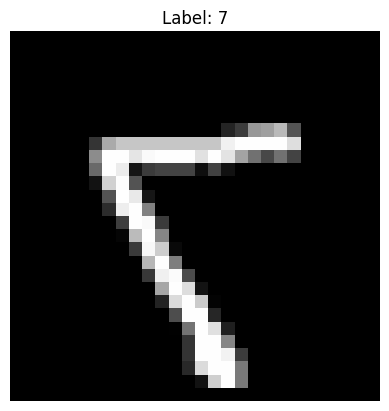

In [ ]:
    original_image = (image * 0.5) + 0.5

    plt.imshow(original_image.permute(1, 2, 0), cmap="gray")
    plt.title(f"Label: {label.item()}")
    plt.axis("off")
    plt.show()

In [ ]:
image = image.to(device)

model1.eval()

with torch.no_grad():
    output = model1(image.unsqueeze(dim=0))
    predicted_class = torch.argmax(output, dim=1).item()

print("True label:", label.item())
print("Predicted label:", predicted_class)

True label: 7
Predicted label: 7


## Model 4

In [71]:
result4_MNIST = fit(model=model4,
                    train_loader=train_dataloader_MNIST,
                    test_loader=test_dataloader_MNIST,
                    loss_fn=loss_fn,
                    optimizer=optimizer4,
                    accuracy_fn=accuracy_fn,
                    device=device,
                    epochs=20)

EPOCH 1/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.17it/s, test_acc=0.972, test_loss=tensor(0.0839, device='cuda:0')]


EPOCH 2/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.90it/s, test_acc=0.984, test_loss=tensor(0.0500, device='cuda:0')]


EPOCH 3/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.68it/s, test_acc=0.987, test_loss=tensor(0.0405, device='cuda:0')]


EPOCH 4/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.91it/s, test_acc=0.984, test_loss=tensor(0.0472, device='cuda:0')]


EPOCH 5/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.92it/s, test_acc=0.987, test_loss=tensor(0.0384, device='cuda:0')]


EPOCH 6/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.73it/s, test_acc=0.989, test_loss=tensor(0.0352, device='cuda:0')]


EPOCH 7/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 21.74it/s, test_acc=0.989, test_loss=tensor(0.0341, device='cuda:0')]


EPOCH 8/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.82it/s, test_acc=0.988, test_loss=tensor(0.0385, device='cuda:0')]


EPOCH 9/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 20.83it/s, test_acc=0.989, test_loss=tensor(0.0343, device='cuda:0')]


EPOCH 10/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.35it/s, test_acc=0.987, test_loss=tensor(0.0404, device='cuda:0')]


EPOCH 11/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 23.80it/s, test_acc=0.987, test_loss=tensor(0.0433, device='cuda:0')]


EPOCH 12/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.40it/s, test_acc=0.99, test_loss=tensor(0.0343, device='cuda:0')]


EPOCH 13/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.15it/s, test_acc=0.99, test_loss=tensor(0.0352, device='cuda:0')]


EPOCH 14/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.49it/s, test_acc=0.99, test_loss=tensor(0.0356, device='cuda:0')]


EPOCH 15/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 20.69it/s, test_acc=0.99, test_loss=tensor(0.0391, device='cuda:0')]


EPOCH 16/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.03it/s, test_acc=0.989, test_loss=tensor(0.0434, device='cuda:0')]


EPOCH 17/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.09it/s, test_acc=0.99, test_loss=tensor(0.0362, device='cuda:0')]


EPOCH 18/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.77it/s, test_acc=0.989, test_loss=tensor(0.0430, device='cuda:0')]


EPOCH 19/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.01it/s, test_acc=0.988, test_loss=tensor(0.0472, device='cuda:0')]


EPOCH 20/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.68it/s, test_acc=0.99, test_loss=tensor(0.0383, device='cuda:0')]

Total training time: 407.015 seconds


In [ ]:
torch.save(model4.state_dict(), "trained_model4.pth")

## Model 7

In [72]:
result7_MNIST = fit(model=model7,
                    train_loader=train_dataloader_MNIST,
                    test_loader=test_dataloader_MNIST,
                    loss_fn=loss_fn,
                    optimizer=optimizer7,
                    accuracy_fn=accuracy_fn,
                    device=device,
                    epochs=20)

EPOCH 1/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.40it/s, test_acc=0.97, test_loss=tensor(0.0992, device='cuda:0')]


EPOCH 2/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.18it/s, test_acc=0.976, test_loss=tensor(0.0780, device='cuda:0')]


EPOCH 3/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.93it/s, test_acc=0.981, test_loss=tensor(0.0546, device='cuda:0')]


EPOCH 4/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.50it/s, test_acc=0.986, test_loss=tensor(0.0448, device='cuda:0')]


EPOCH 5/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.06it/s, test_acc=0.986, test_loss=tensor(0.0426, device='cuda:0')]


EPOCH 6/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.42it/s, test_acc=0.987, test_loss=tensor(0.0428, device='cuda:0')]


EPOCH 7/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.16it/s, test_acc=0.987, test_loss=tensor(0.0378, device='cuda:0')]


EPOCH 8/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.34it/s, test_acc=0.987, test_loss=tensor(0.0376, device='cuda:0')]


EPOCH 9/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.26it/s, test_acc=0.986, test_loss=tensor(0.0403, device='cuda:0')]


EPOCH 10/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.08it/s, test_acc=0.988, test_loss=tensor(0.0399, device='cuda:0')]


EPOCH 11/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.91it/s, test_acc=0.988, test_loss=tensor(0.0383, device='cuda:0')]


EPOCH 12/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.75it/s, test_acc=0.988, test_loss=tensor(0.0377, device='cuda:0')]


EPOCH 13/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 23.55it/s, test_acc=0.99, test_loss=tensor(0.0357, device='cuda:0')]


EPOCH 14/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.67it/s, test_acc=0.99, test_loss=tensor(0.0355, device='cuda:0')]


EPOCH 15/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.40it/s, test_acc=0.99, test_loss=tensor(0.0328, device='cuda:0')]


EPOCH 16/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.75it/s, test_acc=0.989, test_loss=tensor(0.0370, device='cuda:0')]


EPOCH 17/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.61it/s, test_acc=0.99, test_loss=tensor(0.0394, device='cuda:0')]


EPOCH 18/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.48it/s, test_acc=0.99, test_loss=tensor(0.0356, device='cuda:0')]


EPOCH 19/20 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.47it/s, test_acc=0.99, test_loss=tensor(0.0329, device='cuda:0')]


EPOCH 20/20 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.32it/s, test_acc=0.99, test_loss=tensor(0.0387, device='cuda:0')]

Total training time: 387.795 seconds


In [ ]:
torch.save(model7.state_dict(), "trained_model7.pth")

# Fit for FasshinMNIST dataset

## Model 2


In [37]:
result2_FashionMNIST = fit(model=model2,
                           train_loader=train_dataloader_FashionMNIST,
                           test_loader=test_dataloader_FashionMNIST,
                           loss_fn=loss_fn,
                           optimizer=optimizer2,
                           accuracy_fn=accuracy_fn,
                           device=device,
                           epochs=30)

EPOCH 1/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.93it/s, test_acc=0.865, test_loss=tensor(0.3588, device='cuda:0')]


EPOCH 2/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.05it/s, test_acc=0.883, test_loss=tensor(0.3076, device='cuda:0')]


EPOCH 3/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.87it/s, test_acc=0.908, test_loss=tensor(0.2577, device='cuda:0')]


EPOCH 4/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.96it/s, test_acc=0.914, test_loss=tensor(0.2480, device='cuda:0')]


EPOCH 5/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.27it/s, test_acc=0.918, test_loss=tensor(0.2339, device='cuda:0')]


EPOCH 6/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.64it/s, test_acc=0.918, test_loss=tensor(0.2270, device='cuda:0')]


EPOCH 7/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.38it/s, test_acc=0.922, test_loss=tensor(0.2216, device='cuda:0')]


EPOCH 8/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.72it/s, test_acc=0.919, test_loss=tensor(0.2424, device='cuda:0')]


EPOCH 9/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.65it/s, test_acc=0.918, test_loss=tensor(0.2565, device='cuda:0')]


EPOCH 10/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.49it/s, test_acc=0.919, test_loss=tensor(0.2581, device='cuda:0')]


EPOCH 11/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.76it/s, test_acc=0.925, test_loss=tensor(0.2434, device='cuda:0')]


EPOCH 12/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.40it/s, test_acc=0.916, test_loss=tensor(0.2669, device='cuda:0')]


EPOCH 13/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.65it/s, test_acc=0.913, test_loss=tensor(0.2915, device='cuda:0')]


EPOCH 14/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.92it/s, test_acc=0.916, test_loss=tensor(0.2935, device='cuda:0')]


EPOCH 15/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.79it/s, test_acc=0.921, test_loss=tensor(0.3218, device='cuda:0')]


EPOCH 16/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.87it/s, test_acc=0.922, test_loss=tensor(0.3208, device='cuda:0')]


EPOCH 17/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.76it/s, test_acc=0.923, test_loss=tensor(0.3340, device='cuda:0')]


EPOCH 18/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.35it/s, test_acc=0.92, test_loss=tensor(0.3497, device='cuda:0')]


EPOCH 19/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.30it/s, test_acc=0.919, test_loss=tensor(0.4016, device='cuda:0')]


EPOCH 20/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.69it/s, test_acc=0.918, test_loss=tensor(0.3857, device='cuda:0')]


EPOCH 21/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.81it/s, test_acc=0.922, test_loss=tensor(0.3719, device='cuda:0')]


EPOCH 22/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.42it/s, test_acc=0.922, test_loss=tensor(0.4035, device='cuda:0')]


EPOCH 23/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.61it/s, test_acc=0.921, test_loss=tensor(0.4268, device='cuda:0')]


EPOCH 24/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.63it/s, test_acc=0.918, test_loss=tensor(0.4307, device='cuda:0')]


EPOCH 25/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.41it/s, test_acc=0.926, test_loss=tensor(0.4251, device='cuda:0')]


EPOCH 26/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.27it/s, test_acc=0.919, test_loss=tensor(0.4584, device='cuda:0')]


EPOCH 27/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.61it/s, test_acc=0.921, test_loss=tensor(0.4702, device='cuda:0')]


EPOCH 28/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.72it/s, test_acc=0.924, test_loss=tensor(0.4403, device='cuda:0')]


EPOCH 29/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.40it/s, test_acc=0.923, test_loss=tensor(0.4452, device='cuda:0')]


EPOCH 30/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.68it/s, test_acc=0.916, test_loss=tensor(0.4858, device='cuda:0')]

Total training time: 507.083 seconds


In [ ]:
torch.save(model2.state_dict(), "trained_model2.pth")

## Model 5

In [38]:
result5_FashionMNIST = fit(model=model5,
                           train_loader=train_dataloader_FashionMNIST,
                           test_loader=test_dataloader_FashionMNIST,
                           loss_fn=loss_fn,
                           optimizer=optimizer5,
                           accuracy_fn=accuracy_fn,
                           device=device,
                           epochs=30)

EPOCH 1/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.69it/s, test_acc=0.864, test_loss=tensor(0.3650, device='cuda:0')]


EPOCH 2/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.79it/s, test_acc=0.9, test_loss=tensor(0.2743, device='cuda:0')]


EPOCH 3/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.91it/s, test_acc=0.904, test_loss=tensor(0.2732, device='cuda:0')]


EPOCH 4/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.00it/s, test_acc=0.911, test_loss=tensor(0.2426, device='cuda:0')]


EPOCH 5/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.05it/s, test_acc=0.919, test_loss=tensor(0.2341, device='cuda:0')]


EPOCH 6/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.64it/s, test_acc=0.917, test_loss=tensor(0.2391, device='cuda:0')]


EPOCH 7/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.74it/s, test_acc=0.925, test_loss=tensor(0.2151, device='cuda:0')]


EPOCH 8/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.88it/s, test_acc=0.915, test_loss=tensor(0.2377, device='cuda:0')]


EPOCH 9/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.51it/s, test_acc=0.911, test_loss=tensor(0.2508, device='cuda:0')]


EPOCH 10/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.60it/s, test_acc=0.919, test_loss=tensor(0.2549, device='cuda:0')]


EPOCH 11/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.87it/s, test_acc=0.924, test_loss=tensor(0.2601, device='cuda:0')]


EPOCH 12/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.45it/s, test_acc=0.923, test_loss=tensor(0.2617, device='cuda:0')]


EPOCH 13/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.57it/s, test_acc=0.923, test_loss=tensor(0.2674, device='cuda:0')]


EPOCH 14/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.29it/s, test_acc=0.919, test_loss=tensor(0.2944, device='cuda:0')]


EPOCH 15/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.53it/s, test_acc=0.924, test_loss=tensor(0.2784, device='cuda:0')]


EPOCH 16/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.71it/s, test_acc=0.925, test_loss=tensor(0.3135, device='cuda:0')]


EPOCH 17/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.37it/s, test_acc=0.918, test_loss=tensor(0.3370, device='cuda:0')]


EPOCH 18/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.81it/s, test_acc=0.915, test_loss=tensor(0.3552, device='cuda:0')]


EPOCH 19/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.16it/s, test_acc=0.925, test_loss=tensor(0.3628, device='cuda:0')]


EPOCH 20/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.38it/s, test_acc=0.924, test_loss=tensor(0.3510, device='cuda:0')]


EPOCH 21/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.42it/s, test_acc=0.919, test_loss=tensor(0.3773, device='cuda:0')]


EPOCH 22/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.94it/s, test_acc=0.923, test_loss=tensor(0.3793, device='cuda:0')]


EPOCH 23/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.81it/s, test_acc=0.921, test_loss=tensor(0.3851, device='cuda:0')]


EPOCH 24/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.35it/s, test_acc=0.927, test_loss=tensor(0.4155, device='cuda:0')]


EPOCH 25/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.79it/s, test_acc=0.925, test_loss=tensor(0.4099, device='cuda:0')]


EPOCH 26/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.77it/s, test_acc=0.922, test_loss=tensor(0.4365, device='cuda:0')]


EPOCH 27/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.51it/s, test_acc=0.923, test_loss=tensor(0.4261, device='cuda:0')]


EPOCH 28/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.18it/s, test_acc=0.924, test_loss=tensor(0.4436, device='cuda:0')]


EPOCH 29/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.76it/s, test_acc=0.92, test_loss=tensor(0.4775, device='cuda:0')]


EPOCH 30/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.61it/s, test_acc=0.927, test_loss=tensor(0.4599, device='cuda:0')]

Total training time: 515.873 seconds


In [ ]:
torch.save(model5.state_dict(), "trained_model5.pth")

## Model 8

In [39]:
result8_FashionMNIST = fit(model=model8,
                           train_loader=train_dataloader_FashionMNIST,
                           test_loader=test_dataloader_FashionMNIST,
                           loss_fn=loss_fn,
                           optimizer=optimizer8,
                           accuracy_fn=accuracy_fn,
                           device=device,
                           epochs=30)

EPOCH 1/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.66it/s, test_acc=0.858, test_loss=tensor(0.3885, device='cuda:0')]


EPOCH 2/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.88it/s, test_acc=0.881, test_loss=tensor(0.3219, device='cuda:0')]


EPOCH 3/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.78it/s, test_acc=0.886, test_loss=tensor(0.3175, device='cuda:0')]


EPOCH 4/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.75it/s, test_acc=0.9, test_loss=tensor(0.2738, device='cuda:0')]


EPOCH 5/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.16it/s, test_acc=0.912, test_loss=tensor(0.2481, device='cuda:0')]


EPOCH 6/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.42it/s, test_acc=0.914, test_loss=tensor(0.2428, device='cuda:0')]


EPOCH 7/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.10it/s, test_acc=0.918, test_loss=tensor(0.2315, device='cuda:0')]


EPOCH 8/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.05it/s, test_acc=0.924, test_loss=tensor(0.2272, device='cuda:0')]


EPOCH 9/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.52it/s, test_acc=0.919, test_loss=tensor(0.2232, device='cuda:0')]


EPOCH 10/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.79it/s, test_acc=0.921, test_loss=tensor(0.2276, device='cuda:0')]


EPOCH 11/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 34.85it/s, test_acc=0.922, test_loss=tensor(0.2308, device='cuda:0')]


EPOCH 12/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.25it/s, test_acc=0.921, test_loss=tensor(0.2386, device='cuda:0')]


EPOCH 13/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.44it/s, test_acc=0.922, test_loss=tensor(0.2454, device='cuda:0')]


EPOCH 14/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 35.01it/s, test_acc=0.926, test_loss=tensor(0.2241, device='cuda:0')]


EPOCH 15/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.85it/s, test_acc=0.925, test_loss=tensor(0.2327, device='cuda:0')]


EPOCH 16/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.23it/s, test_acc=0.924, test_loss=tensor(0.2476, device='cuda:0')]


EPOCH 17/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.55it/s, test_acc=0.918, test_loss=tensor(0.2527, device='cuda:0')]


EPOCH 18/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.02it/s, test_acc=0.93, test_loss=tensor(0.2443, device='cuda:0')]


EPOCH 19/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.61it/s, test_acc=0.927, test_loss=tensor(0.2567, device='cuda:0')]


EPOCH 20/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.39it/s, test_acc=0.924, test_loss=tensor(0.2677, device='cuda:0')]


EPOCH 21/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.74it/s, test_acc=0.926, test_loss=tensor(0.2755, device='cuda:0')]


EPOCH 22/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.17it/s, test_acc=0.925, test_loss=tensor(0.2810, device='cuda:0')]


EPOCH 23/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.21it/s, test_acc=0.927, test_loss=tensor(0.2904, device='cuda:0')]


EPOCH 24/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.98it/s, test_acc=0.93, test_loss=tensor(0.2946, device='cuda:0')]


EPOCH 25/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 23.23it/s, test_acc=0.924, test_loss=tensor(0.3298, device='cuda:0')]


EPOCH 26/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.34it/s, test_acc=0.927, test_loss=tensor(0.3219, device='cuda:0')]


EPOCH 27/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.19it/s, test_acc=0.926, test_loss=tensor(0.3233, device='cuda:0')]


EPOCH 28/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.87it/s, test_acc=0.927, test_loss=tensor(0.3352, device='cuda:0')]


EPOCH 29/30 :


  test: 100%|██████████| 79/79 [00:02<00:00, 33.19it/s, test_acc=0.927, test_loss=tensor(0.3452, device='cuda:0')]


EPOCH 30/30 :


  test: 100%|██████████| 79/79 [00:03<00:00, 26.03it/s, test_acc=0.923, test_loss=tensor(0.3698, device='cuda:0')]

Total training time: 533.771 seconds


In [ ]:
torch.save(model8.state_dict(), "trained_model8.pth")

# Fit for CIFAR10 dataset

## Model 3

In [ ]:
result3_CIFAR10 = fit(model=model3,
                           train_loader=train_dataloader_CIFAR10,
                           test_loader=test_dataloader_CIFAR10,
                           loss_fn=loss_fn,
                           optimizer=optimizer3,
                           accuracy_fn=accuracy_fn,
                           device=device,
                           epochs=40)

EPOCH 1/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.54it/s, test_acc=0.57, test_loss=tensor(1.1875, device='cuda:0')]


EPOCH 2/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.71it/s, test_acc=0.687, test_loss=tensor(0.9166, device='cuda:0')]


EPOCH 3/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.74it/s, test_acc=0.713, test_loss=tensor(0.8181, device='cuda:0')]


EPOCH 4/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.77it/s, test_acc=0.732, test_loss=tensor(0.7834, device='cuda:0')]


EPOCH 5/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.32it/s, test_acc=0.735, test_loss=tensor(0.7677, device='cuda:0')]


EPOCH 6/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.35it/s, test_acc=0.75, test_loss=tensor(0.7698, device='cuda:0')]


EPOCH 7/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.61it/s, test_acc=0.752, test_loss=tensor(0.7815, device='cuda:0')]


EPOCH 8/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.59it/s, test_acc=0.748, test_loss=tensor(0.8148, device='cuda:0')]


EPOCH 9/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.73it/s, test_acc=0.758, test_loss=tensor(0.8499, device='cuda:0')]


EPOCH 10/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.87it/s, test_acc=0.744, test_loss=tensor(0.8982, device='cuda:0')]


EPOCH 11/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.32it/s, test_acc=0.753, test_loss=tensor(0.9850, device='cuda:0')]


EPOCH 12/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 23.23it/s, test_acc=0.756, test_loss=tensor(0.9990, device='cuda:0')]


EPOCH 13/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.17it/s, test_acc=0.762, test_loss=tensor(1.0063, device='cuda:0')]


EPOCH 14/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.32it/s, test_acc=0.756, test_loss=tensor(1.0679, device='cuda:0')]


EPOCH 15/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.30it/s, test_acc=0.756, test_loss=tensor(1.1824, device='cuda:0')]


EPOCH 16/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.40it/s, test_acc=0.762, test_loss=tensor(1.2312, device='cuda:0')]


EPOCH 17/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.05it/s, test_acc=0.767, test_loss=tensor(1.2252, device='cuda:0')]


EPOCH 18/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.11it/s, test_acc=0.756, test_loss=tensor(1.3121, device='cuda:0')]


EPOCH 19/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 21.85it/s, test_acc=0.755, test_loss=tensor(1.3444, device='cuda:0')]


EPOCH 20/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.01it/s, test_acc=0.757, test_loss=tensor(1.3244, device='cuda:0')]


EPOCH 21/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.16it/s, test_acc=0.754, test_loss=tensor(1.3956, device='cuda:0')]


EPOCH 22/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 25.96it/s, test_acc=0.759, test_loss=tensor(1.4492, device='cuda:0')]


EPOCH 23/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.31it/s, test_acc=0.764, test_loss=tensor(1.4781, device='cuda:0')]


EPOCH 24/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.81it/s, test_acc=0.751, test_loss=tensor(1.5044, device='cuda:0')]


EPOCH 25/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.55it/s, test_acc=0.766, test_loss=tensor(1.5412, device='cuda:0')]


EPOCH 26/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 23.42it/s, test_acc=0.764, test_loss=tensor(1.5625, device='cuda:0')]


EPOCH 27/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.79it/s, test_acc=0.761, test_loss=tensor(1.5786, device='cuda:0')]


EPOCH 28/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.94it/s, test_acc=0.765, test_loss=tensor(1.5386, device='cuda:0')]


EPOCH 29/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.95it/s, test_acc=0.764, test_loss=tensor(1.5464, device='cuda:0')]


EPOCH 30/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.47it/s, test_acc=0.765, test_loss=tensor(1.6475, device='cuda:0')]


EPOCH 31/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.15it/s, test_acc=0.757, test_loss=tensor(1.7139, device='cuda:0')]


EPOCH 32/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.69it/s, test_acc=0.765, test_loss=tensor(1.6481, device='cuda:0')]


EPOCH 33/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.60it/s, test_acc=0.767, test_loss=tensor(1.6424, device='cuda:0')]


EPOCH 34/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.36it/s, test_acc=0.751, test_loss=tensor(1.7346, device='cuda:0')]


EPOCH 35/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.47it/s, test_acc=0.766, test_loss=tensor(1.7006, device='cuda:0')]


EPOCH 36/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.38it/s, test_acc=0.758, test_loss=tensor(1.7285, device='cuda:0')]


EPOCH 37/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 32.00it/s, test_acc=0.758, test_loss=tensor(1.6780, device='cuda:0')]


EPOCH 38/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.50it/s, test_acc=0.766, test_loss=tensor(1.8030, device='cuda:0')]


EPOCH 39/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.59it/s, test_acc=0.769, test_loss=tensor(1.7764, device='cuda:0')]


EPOCH 40/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 26.28it/s, test_acc=0.768, test_loss=tensor(1.7364, device='cuda:0')]

Total training time: 666.495 seconds


In [ ]:
torch.save(model3.state_dict(), "trained_model3.pth")

## Model 6

In [ ]:
result6_CIFAR10 = fit(model=model6,
                           train_loader=train_dataloader_CIFAR10,
                           test_loader=test_dataloader_CIFAR10,
                           loss_fn=loss_fn,
                           optimizer=optimizer6,
                           accuracy_fn=accuracy_fn,
                           device=device,
                           epochs=40)

EPOCH 1/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.26it/s, test_acc=0.571, test_loss=tensor(1.1992, device='cuda:0')]


EPOCH 2/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.83it/s, test_acc=0.667, test_loss=tensor(0.9525, device='cuda:0')]


EPOCH 3/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.15it/s, test_acc=0.705, test_loss=tensor(0.8492, device='cuda:0')]


EPOCH 4/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.20it/s, test_acc=0.72, test_loss=tensor(0.8186, device='cuda:0')]


EPOCH 5/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 26.08it/s, test_acc=0.75, test_loss=tensor(0.7573, device='cuda:0')]


EPOCH 6/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.48it/s, test_acc=0.755, test_loss=tensor(0.7299, device='cuda:0')]


EPOCH 7/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.07it/s, test_acc=0.763, test_loss=tensor(0.7567, device='cuda:0')]


EPOCH 8/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.99it/s, test_acc=0.75, test_loss=tensor(0.8145, device='cuda:0')]


EPOCH 9/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 21.67it/s, test_acc=0.755, test_loss=tensor(0.8710, device='cuda:0')]


EPOCH 10/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.47it/s, test_acc=0.764, test_loss=tensor(0.8873, device='cuda:0')]


EPOCH 11/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.76it/s, test_acc=0.757, test_loss=tensor(0.9586, device='cuda:0')]


EPOCH 12/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 21.06it/s, test_acc=0.755, test_loss=tensor(1.0671, device='cuda:0')]


EPOCH 13/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.79it/s, test_acc=0.758, test_loss=tensor(1.0932, device='cuda:0')]


EPOCH 14/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.89it/s, test_acc=0.762, test_loss=tensor(1.1553, device='cuda:0')]


EPOCH 15/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 21.38it/s, test_acc=0.761, test_loss=tensor(1.1529, device='cuda:0')]


EPOCH 16/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.31it/s, test_acc=0.764, test_loss=tensor(1.2351, device='cuda:0')]


EPOCH 17/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.83it/s, test_acc=0.767, test_loss=tensor(1.2739, device='cuda:0')]


EPOCH 18/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.33it/s, test_acc=0.76, test_loss=tensor(1.3236, device='cuda:0')]


EPOCH 19/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.75it/s, test_acc=0.755, test_loss=tensor(1.3810, device='cuda:0')]


EPOCH 20/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.27it/s, test_acc=0.76, test_loss=tensor(1.3730, device='cuda:0')]


EPOCH 21/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.06it/s, test_acc=0.759, test_loss=tensor(1.4053, device='cuda:0')]


EPOCH 22/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.89it/s, test_acc=0.766, test_loss=tensor(1.4097, device='cuda:0')]


EPOCH 23/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.86it/s, test_acc=0.764, test_loss=tensor(1.5206, device='cuda:0')]


EPOCH 24/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.17it/s, test_acc=0.767, test_loss=tensor(1.4274, device='cuda:0')]


EPOCH 25/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.18it/s, test_acc=0.769, test_loss=tensor(1.5678, device='cuda:0')]


EPOCH 26/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.97it/s, test_acc=0.765, test_loss=tensor(1.4955, device='cuda:0')]


EPOCH 27/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.04it/s, test_acc=0.765, test_loss=tensor(1.6423, device='cuda:0')]


EPOCH 28/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 21.93it/s, test_acc=0.772, test_loss=tensor(1.5517, device='cuda:0')]


EPOCH 29/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.76it/s, test_acc=0.765, test_loss=tensor(1.5947, device='cuda:0')]


EPOCH 30/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.82it/s, test_acc=0.765, test_loss=tensor(1.6616, device='cuda:0')]


EPOCH 31/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.67it/s, test_acc=0.764, test_loss=tensor(1.6419, device='cuda:0')]


EPOCH 32/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.54it/s, test_acc=0.772, test_loss=tensor(1.6562, device='cuda:0')]


EPOCH 33/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.28it/s, test_acc=0.763, test_loss=tensor(1.6706, device='cuda:0')]


EPOCH 34/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 26.74it/s, test_acc=0.767, test_loss=tensor(1.6957, device='cuda:0')]


EPOCH 35/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.96it/s, test_acc=0.774, test_loss=tensor(1.6617, device='cuda:0')]


EPOCH 36/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.71it/s, test_acc=0.768, test_loss=tensor(1.7408, device='cuda:0')]


EPOCH 37/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.79it/s, test_acc=0.771, test_loss=tensor(1.7487, device='cuda:0')]


EPOCH 38/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.53it/s, test_acc=0.767, test_loss=tensor(1.8148, device='cuda:0')]


EPOCH 39/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.13it/s, test_acc=0.76, test_loss=tensor(1.8118, device='cuda:0')]


EPOCH 40/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.81it/s, test_acc=0.775, test_loss=tensor(1.7676, device='cuda:0')]

Total training time: 670.885 seconds


In [ ]:
torch.save(model6.state_dict(), "trained_model6.pth")

## Model 9

In [ ]:
result9_CIFAR10 = fit(model=model9,
                           train_loader=train_dataloader_CIFAR10,
                           test_loader=test_dataloader_CIFAR10,
                           loss_fn=loss_fn,
                           optimizer=optimizer9,
                           accuracy_fn=accuracy_fn,
                           device=device,
                           epochs=40)

EPOCH 1/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.32it/s, test_acc=0.575, test_loss=tensor(1.2045, device='cuda:0')]


EPOCH 2/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.14it/s, test_acc=0.661, test_loss=tensor(0.9557, device='cuda:0')]


EPOCH 3/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 28.72it/s, test_acc=0.699, test_loss=tensor(0.8481, device='cuda:0')]


EPOCH 4/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.32it/s, test_acc=0.719, test_loss=tensor(0.8076, device='cuda:0')]


EPOCH 5/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.38it/s, test_acc=0.738, test_loss=tensor(0.7602, device='cuda:0')]


EPOCH 6/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.83it/s, test_acc=0.745, test_loss=tensor(0.7457, device='cuda:0')]


EPOCH 7/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 24.23it/s, test_acc=0.752, test_loss=tensor(0.7318, device='cuda:0')]


EPOCH 8/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 31.29it/s, test_acc=0.764, test_loss=tensor(0.7276, device='cuda:0')]


EPOCH 9/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.81it/s, test_acc=0.759, test_loss=tensor(0.7787, device='cuda:0')]


EPOCH 10/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.12it/s, test_acc=0.758, test_loss=tensor(0.8297, device='cuda:0')]


EPOCH 11/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.01it/s, test_acc=0.759, test_loss=tensor(0.8640, device='cuda:0')]


EPOCH 12/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.02it/s, test_acc=0.77, test_loss=tensor(0.8743, device='cuda:0')]


EPOCH 13/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.86it/s, test_acc=0.777, test_loss=tensor(0.9408, device='cuda:0')]


EPOCH 14/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.65it/s, test_acc=0.769, test_loss=tensor(0.9803, device='cuda:0')]


EPOCH 15/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.81it/s, test_acc=0.774, test_loss=tensor(1.0310, device='cuda:0')]


EPOCH 16/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 23.57it/s, test_acc=0.773, test_loss=tensor(1.0895, device='cuda:0')]


EPOCH 17/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.21it/s, test_acc=0.776, test_loss=tensor(1.0937, device='cuda:0')]


EPOCH 18/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.97it/s, test_acc=0.777, test_loss=tensor(1.1304, device='cuda:0')]


EPOCH 19/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 26.17it/s, test_acc=0.785, test_loss=tensor(1.1781, device='cuda:0')]


EPOCH 20/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.02it/s, test_acc=0.775, test_loss=tensor(1.2075, device='cuda:0')]


EPOCH 21/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.26it/s, test_acc=0.775, test_loss=tensor(1.2666, device='cuda:0')]


EPOCH 22/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.68it/s, test_acc=0.768, test_loss=tensor(1.2683, device='cuda:0')]


EPOCH 23/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 26.93it/s, test_acc=0.777, test_loss=tensor(1.2663, device='cuda:0')]


EPOCH 24/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.64it/s, test_acc=0.775, test_loss=tensor(1.3116, device='cuda:0')]


EPOCH 25/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.37it/s, test_acc=0.778, test_loss=tensor(1.3412, device='cuda:0')]


EPOCH 26/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.15it/s, test_acc=0.784, test_loss=tensor(1.3300, device='cuda:0')]


EPOCH 27/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.80it/s, test_acc=0.778, test_loss=tensor(1.3759, device='cuda:0')]


EPOCH 28/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.51it/s, test_acc=0.786, test_loss=tensor(1.4083, device='cuda:0')]


EPOCH 29/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 26.95it/s, test_acc=0.786, test_loss=tensor(1.4274, device='cuda:0')]


EPOCH 30/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.67it/s, test_acc=0.79, test_loss=tensor(1.4065, device='cuda:0')]


EPOCH 31/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.84it/s, test_acc=0.788, test_loss=tensor(1.4263, device='cuda:0')]


EPOCH 32/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.18it/s, test_acc=0.788, test_loss=tensor(1.4555, device='cuda:0')]


EPOCH 33/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 23.21it/s, test_acc=0.792, test_loss=tensor(1.4355, device='cuda:0')]


EPOCH 34/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.07it/s, test_acc=0.789, test_loss=tensor(1.4652, device='cuda:0')]


EPOCH 35/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.48it/s, test_acc=0.792, test_loss=tensor(1.4966, device='cuda:0')]


EPOCH 36/40 :


  test: 100%|██████████| 79/79 [00:03<00:00, 22.69it/s, test_acc=0.788, test_loss=tensor(1.4959, device='cuda:0')]


EPOCH 37/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.75it/s, test_acc=0.792, test_loss=tensor(1.4971, device='cuda:0')]


EPOCH 38/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 30.04it/s, test_acc=0.796, test_loss=tensor(1.5032, device='cuda:0')]


EPOCH 39/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 27.24it/s, test_acc=0.792, test_loss=tensor(1.5044, device='cuda:0')]


EPOCH 40/40 :


  test: 100%|██████████| 79/79 [00:02<00:00, 29.08it/s, test_acc=0.794, test_loss=tensor(1.4892, device='cuda:0')]

Total training time: 670.830 seconds


In [ ]:
torch.save(model9.state_dict(), "trained_model9.pth")

# Show the results

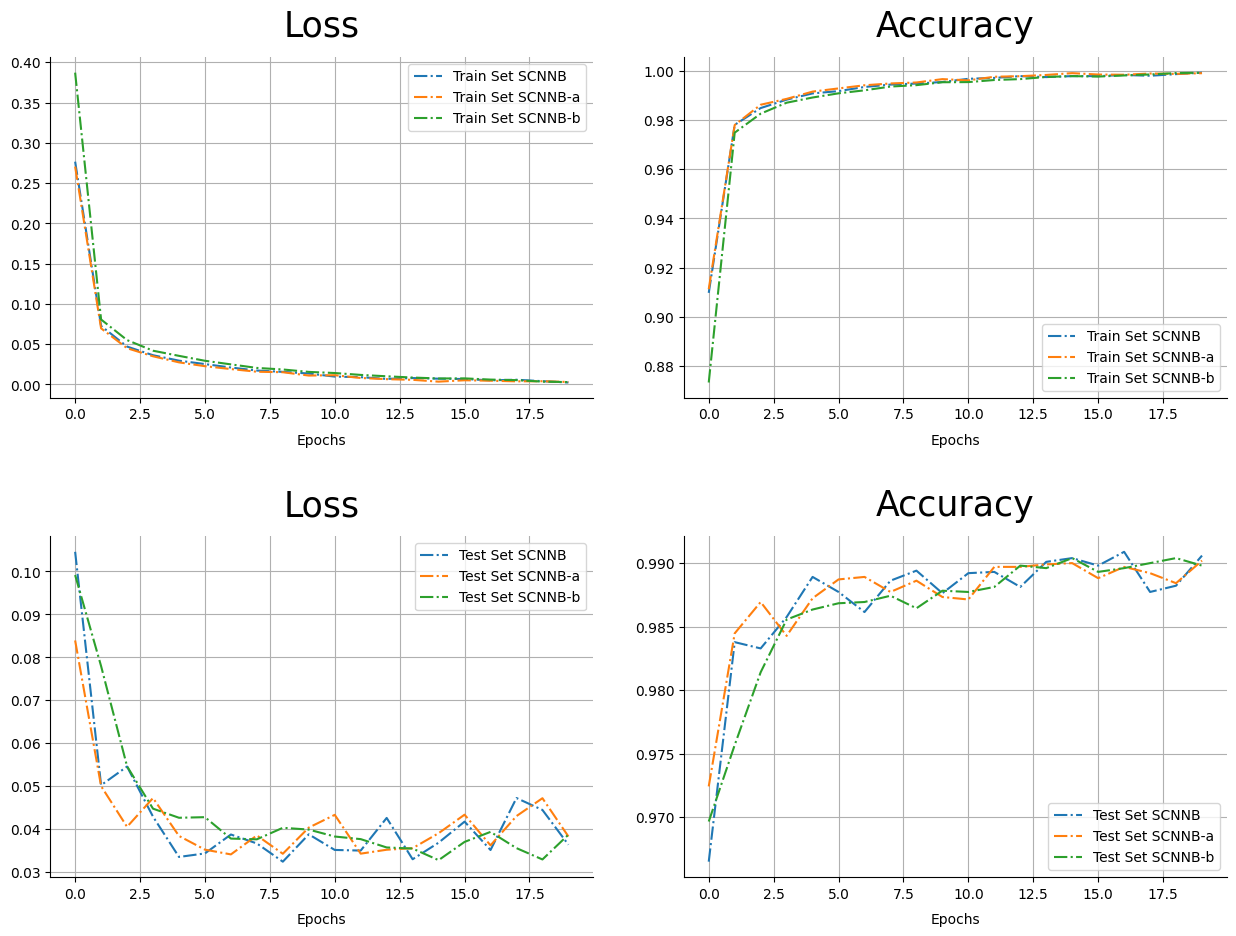

In [73]:
accloss_plots(result1_MNIST['train_loss'], result1_MNIST['test_loss'], result1_MNIST['train_acc'], result1_MNIST['test_acc'],
              result4_MNIST['train_loss'], result4_MNIST['test_loss'], result4_MNIST['train_acc'], result4_MNIST['test_acc'],
              result7_MNIST['train_loss'], result7_MNIST['test_loss'], result7_MNIST['train_acc'], result7_MNIST['test_acc'])

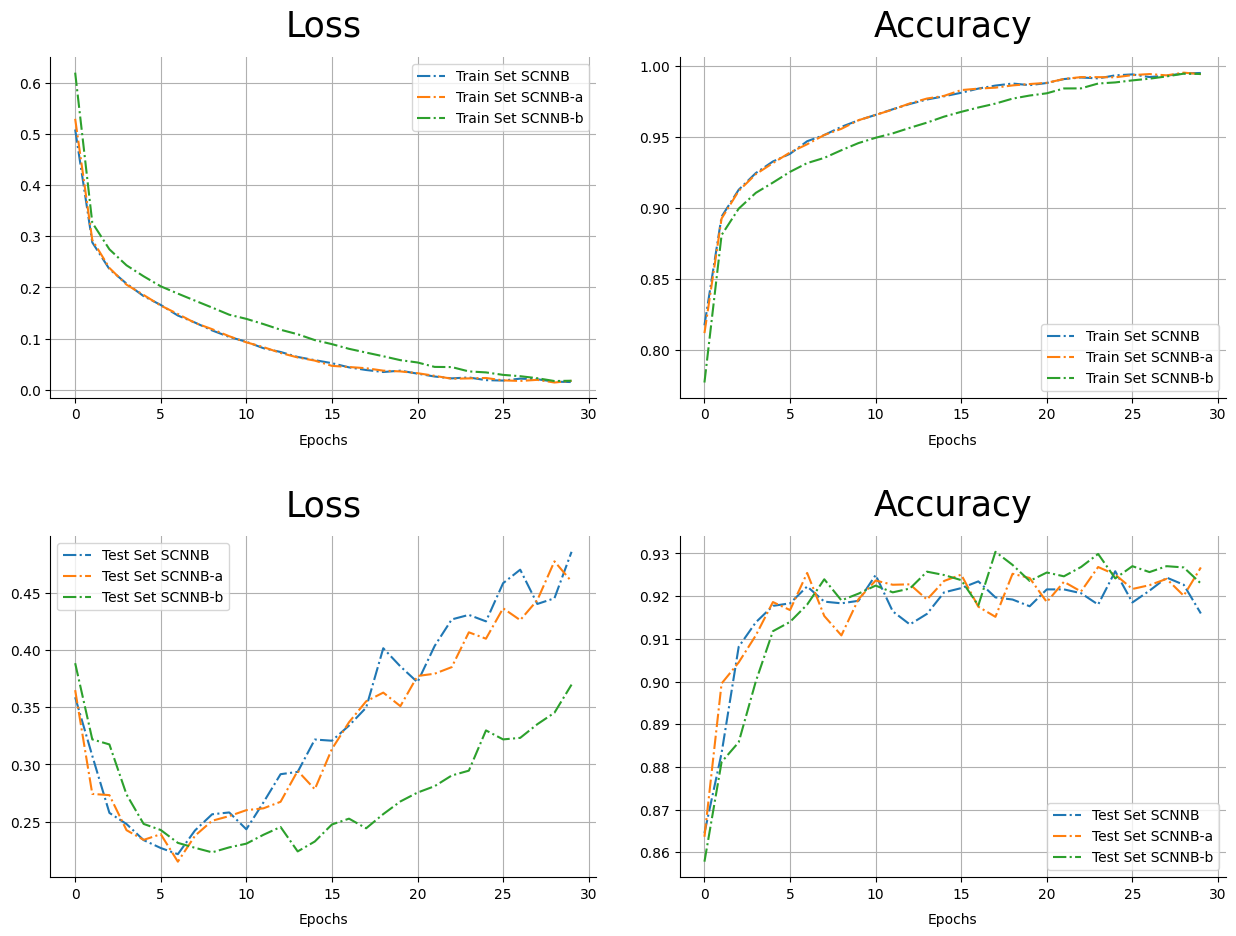

In [42]:
accloss_plots(result2_FashionMNIST['train_loss'], result2_FashionMNIST['test_loss'], result2_FashionMNIST['train_acc'], result2_FashionMNIST['test_acc'],
              result5_FashionMNIST['train_loss'], result5_FashionMNIST['test_loss'], result5_FashionMNIST['train_acc'], result5_FashionMNIST['test_acc'],
              result8_FashionMNIST['train_loss'], result8_FashionMNIST['test_loss'], result8_FashionMNIST['train_acc'], result8_FashionMNIST['test_acc'])

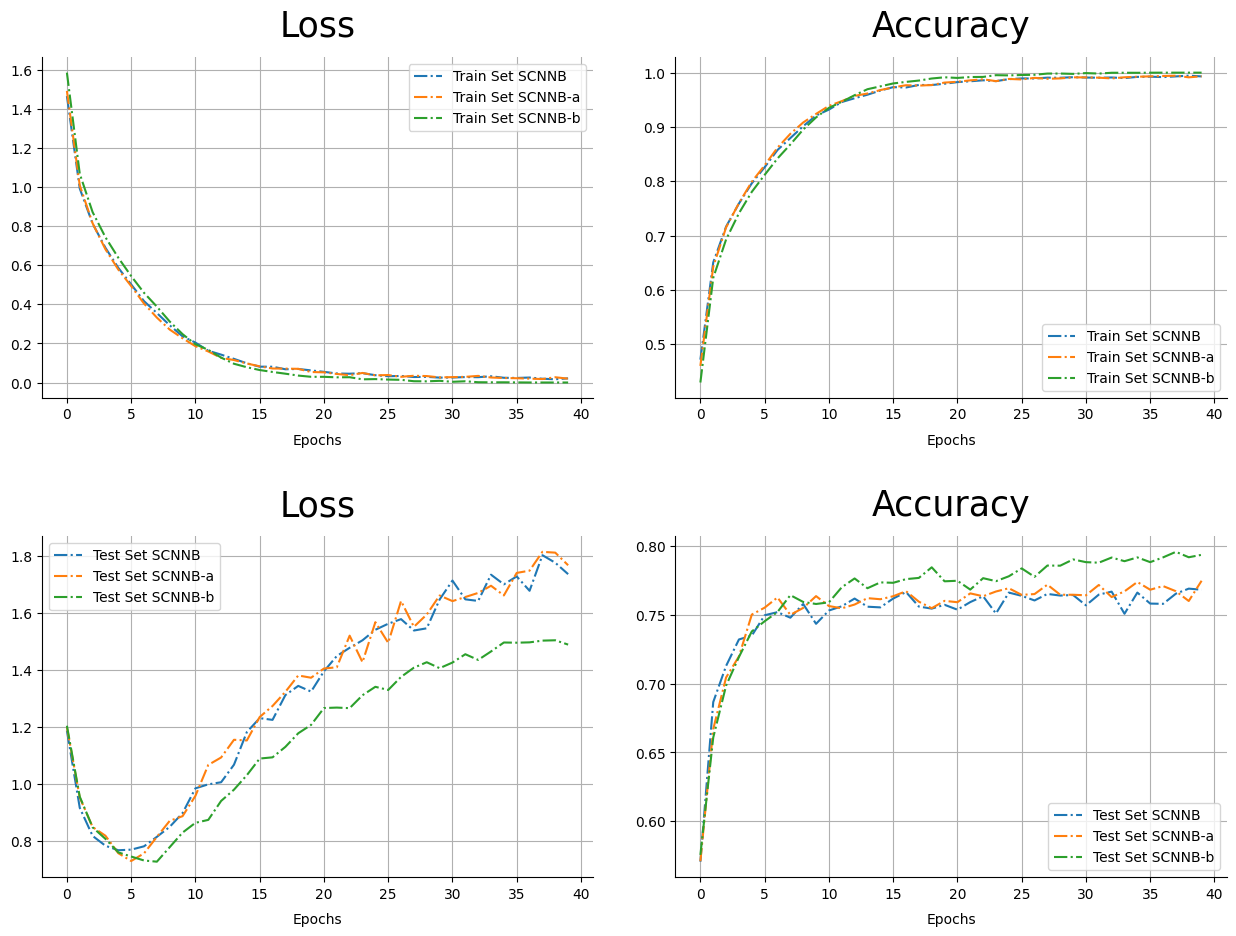

In [ ]:
accloss_plots(result3_CIFAR10['train_loss'], result3_CIFAR10['test_loss'], result3_CIFAR10['train_acc'], result3_CIFAR10['test_acc'],
              result6_CIFAR10['train_loss'], result6_CIFAR10['test_loss'], result6_CIFAR10['train_acc'], result6_CIFAR10['test_acc'],
              result9_CIFAR10['train_loss'], result9_CIFAR10['test_loss'], result9_CIFAR10['train_acc'], result9_CIFAR10['test_acc'])